In [1]:
%reload_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd # python data manipulation and analysis library
import numpy as np #  Library with large collection of high-level mathematical functions to operate on arrays
import matplotlib.pyplot as plt #python plotting library
import peakutils #baselining library

import os, glob, csv
 # Library with operating system dependent functionality. Example: Reading data from files on the computer

from lmfit import Parameters, minimize

## File handling

In [3]:
bg1 = max(glob.glob('*1500wavenumber.csv'), key=os.path.getctime)  # bg_G
fn1 = max(glob.glob('*GD.csv'), key=os.path.getctime)  # fn_G

bg2 = max(glob.glob('*2700wavenumber.csv'), key=os.path.getctime)  # bg_2D
fn2 = max(glob.glob('*_2D.csv'), key=os.path.getctime)  # fn_2D  

In [ ]:
fn1 = 'foreground1D.csv'
fn2 = 'foreground2D.csv'

## Preprocessing

In [4]:
d1 = pd.read_csv(fn1)
d1_ = pd.read_csv(bg1)
d1['I']=d1['I']-d1_['I']
base1 = peakutils.baseline(d1['I'], 1)
d1['I_base']= d1['I']-base1
# d1 = d1[(d1['W']>1250) & (d1['W']<1750)]

d2 = pd.read_csv(fn2)
d2_ = pd.read_csv(bg2)
d2['I']=d2['I']-d2_['I']
base2 = peakutils.baseline(d2['I'], 1)
d2['I_base']= d2['I']-base2
# d2 = d2[(d2['W']>2600) & (d2['W']<2850)]

## Inspect plot

In [5]:
standardFonts = {'family' : 'Arial',
                 'size' : 14}

subplotLabels = {'fontsize': rcParams['axes.titlesize'],
                 'fontweight' : 'bold',
                 'verticalalignment': 'baseline',
                 'horizontalalignment': 'left'}
    
matplotlib.rc('font', **standardFonts)
mpl.rcParams['mathtext.fontset']  = 'dejavuserif'
mpl.rcParams['font.family']       = 'Arial'
matplotlib.rc('font', **standardFonts)

mpl.rcParams['xtick.major.size']  = 8
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size']  = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.direction']   = 'in'
mpl.rcParams['xtick.top']         = True
mpl.rcParams['xtick.bottom']      = True
mpl.rcParams['xtick.labelsize']   = 16
mpl.rcParams['ytick.major.size']  = 8
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size']  = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.direction']   = 'in'
mpl.rcParams['ytick.left']        = True
mpl.rcParams['ytick.right']       = True
mpl.rcParams['ytick.labelsize']   = 16

mpl.rcParams['axes.linewidth']    = 2
mpl.rcParams['axes.titlesize']    = 20
mpl.rcParams['axes.titleweight']  = 'bold'
mpl.rcParams['axes.labelweight']  = 'bold'
mpl.rcParams['axes.labelsize']    = 16

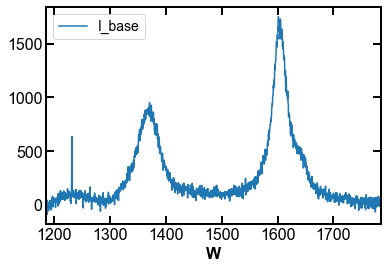

In [6]:
d1.plot('W','I_base')

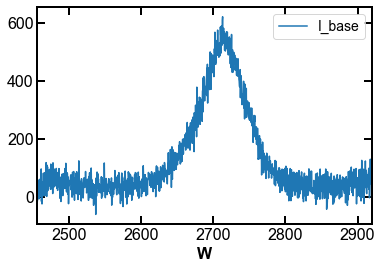

In [7]:
d2.plot('W','I_base')

## Fitting

In [8]:
def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp * (GammaL**2 / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp * np.exp( -((WavNr - Pos)/SigmaG)**2) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

In [9]:
def one_pv(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    a3 = pars['a3'].value
    c3 = pars['c3'].value
    s3 = pars['s3'].value
    f3 = pars['f3'].value
    
#     background = line(x, m, c)
    peak1 = PseudoVoigtFunction(x.astype(float),c3, a3, s3, f3)
#     peak2 = PseudoVoigtFunction(x.astype(float),c2, a2, s2, f2)
    
    model =  peak1  # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

def two_pv(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    a1 = pars['a1'].value
    c1 = pars['c1'].value
    s1 = pars['s1'].value
    f1 = pars['f1'].value
    
    
    a2 = pars['a2'].value
    c2 = pars['c2'].value
    s2 = pars['s2'].value
    f2 = pars['f2'].value
    
    
#     m = pars['m'].value
#     c = pars['c'].value
    
#     background = line(x, m, c)
    peak1 = PseudoVoigtFunction(x.astype(float),c1, a1, s1, f1)
    peak2 = PseudoVoigtFunction(x.astype(float),c2, a2, s2, f2)
    
    model =  peak1 + peak2  # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1, peak2
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

In [11]:
ps1 = Parameters()

#            (Name,  Value,  Vary,   Min,  Max,  Expr)
ps1.add_many(('a1',    1 ,   True,     0, None,  None),
             ('c1',   1350,   True,  1330, 1370,  None),
             ('s1',     20,   True,    10,   1000,  None),  # 1000 so that we get proper fit width of unpatterned peak 
             ('f1',    0.5,   True,  None, 1,  None),
             ('a2',      1,   True,     0, None,  None),
             ('c2',    1600,   True, 1560,  1640,  None),
             ('s2',     20,   True,    10,   1000,  None),
             ('f2',    0.5,   True,  None, 1,  None))

ps2 = Parameters()

#            (Name,  Value,  Vary,   Min,  Max,  Expr)
ps2.add_many(('a3',      1,   True,     0, None,  None),
             ('c3',    2700,   True, 2650,  2750,  None),
             ('s3',     20,   True,    10,   1000,  None),
             ('f3',    0.5,   True,  None, 1,  None))

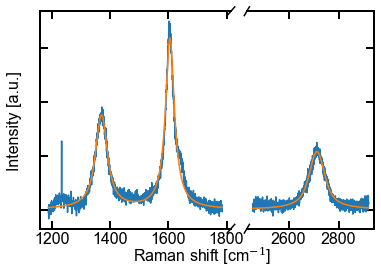

In [12]:
x = d1['W']
y = d1['I_base']
out = minimize(two_pv, ps1, method = 'leastsq', args=(x, y))
df1 = pd.DataFrame({key: [par.value] for key, par in out.params.items()})

x2 = d2['W']
y2 = d2['I_base']
out2 = minimize(one_pv, ps2, method = 'leastsq', args=(x2, y2))
df2 = pd.DataFrame({key: [par.value] for key, par in out2.params.items()})
df = pd.concat([df1,df2],axis=1)

f, (ax,ax2)=plt.subplots(1,2,sharey=True, gridspec_kw = {'width_ratios':[1.5, 1]})
f.subplots_adjust(wspace=0.1)

ax.xaxis.set_major_locator(MultipleLocator(200))
ax2.xaxis.set_major_locator(MultipleLocator(200))

ax.set_yticklabels([])

ax.plot(x,y,'-',label='measured',)
ax.plot(x,two_pv(out.params, x)[0],label='fit')
ax2.plot(x2,y2,'-')
ax2.plot(x2,one_pv(out2.params, x2)[0])

f.text(0.05, 0.5, 'Intensity [a.u.]', va='center', rotation='vertical', fontsize=16)
f.text(0.5, 0.01, 'Raman shift [cm$^{-1}$]', ha='center', rotation='horizontal',fontsize=16)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
# ax.tick_params(labelright='off')  # don't put tick labels at the top
ax2.yaxis.tick_right()
# ax.yaxis.label('test')

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, + d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((- d, + d), (- d, + d), **kwargs)  # bottom-left diagonal
ax2.plot((- d, + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# ax.legend(loc='upper right')
# plt.savefig(p/'Raman_raw_111.png', format='png', dpi=300)
plt.show()

In [13]:
if (out.params['s1'].value or out.params['s2'].value  or out2.params['s3'].value) < 100: # convergence threshold
    df1 = pd.DataFrame({key: [par.value] for key, par in out.params.items()})
    df2 = pd.DataFrame({key: [par.value] for key, par in out2.params.items()})
    df = pd.concat([df1,df2],axis=1)
else:
    df1 = pd.DataFrame({key: [par.value] for key, par in out.params.items()})
    df2 = pd.DataFrame({key: [par.value] for key, par in out2.params.items()})
    df = pd.concat([df1,df2],axis=1)
    df.iloc[0,:]=0

df

,a1,c1,s1,f1,a2,c2,s2,f2,a3,c3,s3,f3
0,869.055467,1369.140296,27.299245,0.804699,1583.479321,1605.025218,18.603281,1.0,537.552039,2713.548463,43.16791,0.692512


## Post-processing for ML-csv

In [14]:
df.columns= ['D','PD','WD','FD','G','PG','WG','FG','2D','P2D','W2D','F2D']
df['GD']=df['G']/df['D']
df['2DG']=df['2D']/df['G']
df

,D,PD,WD,FD,G,PG,WG,FG,2D,P2D,W2D,F2D,GD,2DG
0,869.055467,1369.140296,27.299245,0.804699,1583.479321,1605.025218,18.603281,1.0,537.552039,2713.548463,43.16791,0.692512,1.822069,0.339475


In [ ]:
with open('foo.csv','w') as f:
    f.write('\n')    
df.to_csv('foo.csv', mode='a')